## Forecasting with ARIMA / SARIMA

Generally these set of models did not perform very well (3.7 - 3.8 Kaggle score), even when we tried forecasting on different sub groups of the data (i.e. product category, region), and factored in the seasonality into SARIMA with m = 7. 

These models were trained using the mean number of units sold across all items, so that instead of 30K items to predict for each time point, we only needed for 1 item (the mean items across 30k items) for each time point. This helped with running the models on the entire time period, however it probably impacted performance of the model significantly since it is very difficult to assume 1 time series can effectively act as a proxy for 30K individual time series.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from pmdarima.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller, kpss

In [2]:
TRAIN_CSV_PATH = r"../datasets/train.csv"
PRICES_CSV_PATH = r"../datasets/prices.csv"
CAL_CSV_PATH = r"../datasets/calendar.csv"
SAMPLE_CSV_PATH = r"../datasets/sample_submission.csv"

EXPORT_PATH = r"../submissions/"

In [3]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [4]:
def plot_differencing(series, n = 8) :
    """
    Function to plot a differenced series along with ACF and PACF plots for each order of differencing. 
    Default is plotting until the 7th order.
    """
    
    fig, axes = plt.subplots(n, 3, figsize = (20,25))

    axes[0, 0].plot(series); axes[0, 0].set_title('Original Series')
    plot_acf(series, ax=axes[0, 1])

    for i in range(1, n) :
        diff_series = series.diff(periods = i)

        axes[i, 0].plot(diff_series); axes[i, 0].set_title(f'{i}th Order Differencing')
        plot_acf(diff_series.dropna(), ax=axes[i, 1])
        plot_pacf(diff_series.dropna(), method='ywm', ax = axes[i, 2])

    plt.show()

In [5]:
df_train = pd.read_csv(TRAIN_CSV_PATH)
df_cal = pd.read_csv(CAL_CSV_PATH)

Data cleaning before running models

In [6]:
# Convert to appropriate datatypes
string_features = ["id", "item_id", "subcat_id", "category_id", "store_id", "region_id"]
for f in string_features :
    df_train[f] = df_train[f].astype("string")

# Change dtypes
df_cal["date"] = pd.to_datetime(df_cal["date"])
df_cal["weekday"] = df_cal["weekday"].astype("string")
df_cal["d"] = df_cal["d"].astype("string")
df_cal["wm_yr_wk"] = df_cal["wm_yr_wk"].astype(int)

# Save day IDs from train
day_ids = list(df_train.columns[6:])
df_items_temp = df_train[["id"]+day_ids].T
df_items_temp.columns = df_items_temp.iloc[0, :]

# Drop first row
df_items_temp = df_items_temp.iloc[1: , :]

# Copy the index to merge date
df_items_temp["d"] = df_items_temp.index

# Merge date into df
df_items_temp = pd.merge(df_items_temp, df_cal, on = "d", how = "left")
df_items_temp = df_items_temp.set_index("date")

# Calculate average items across items per day
df_items_temp["avg_items_sold"] = df_items_temp[list(df_train["id"])].mean(axis = 1)
df_items_temp.head()

,Beauty_1_001_East_1,Beauty_1_002_East_1,Beauty_1_003_East_1,Beauty_1_004_East_1,Beauty_1_005_East_1,Beauty_1_006_East_1,Beauty_1_007_East_1,Beauty_1_008_East_1,Beauty_1_009_East_1,Beauty_1_010_East_1,...,Food_3_825_West_3,Food_3_826_West_3,Food_3_827_West_3,d,wm_yr_wk,weekday,wday,month,year,avg_items_sold
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,12,2,0,...,0,0,0,d_1,11101,Saturday,1,1,2011,1.070220
2011-01-30,0,0,0,0,0,0,0,15,0,0,...,6,0,0,d_2,11101,Sunday,2,1,2011,1.041292
2011-01-31,0,0,0,0,0,0,0,0,7,1,...,0,0,0,d_3,11101,Monday,3,1,2011,0.780026
2011-02-01,0,0,0,0,0,0,0,0,3,0,...,2,0,0,d_4,11101,Tuesday,4,2,2011,0.833454
2011-02-02,0,0,0,0,0,0,0,0,0,0,...,2,0,0,d_5,11101,Wednesday,5,2,2011,0.627944


#### Plot differencing for lag 1 - 7 and generate hypothesis for ARIMA / SARIMA

As can be seen from the plot below, the ACF and PACF plots only have decreasing correlation at difference = 7, suggesting that we should difference by 7 first, then use an ARIMA model. Alternatively, we could just use a SARIMA model specifying that seasonality = 7 and let the algorithm handle it for us.

At the 7th order differenced series, the ACF plot shows high auto correlation at lag = 7, suggesting that there is still seasonality for the next 7 days. So there is one seasonality for 7, and then another 14 days later, which is confirmed by our EDA plots.

As for the PACF plot, at difference = 7, we see high partial autocorrelation at lag = 7, 14 and 21 (each one very slightly lower than the next), until when lag = 28 where the partial autocorrelation is still relatively high, but much less compared to 7, 14 and 21.

In terms of the residuals, we see that they have the lowest variance at diff = 7 as well, removing the the upwards trend of the original series. The residuals are also centered around 0, with certain spikes at notably the end of each year, where all the stores close.

Formulating hypothesis for paramters:
- m = 7 (seasonality)
- p = 3 (according to PACF at lag 7, where at the 4th lag, the correlation was insiginficant. So the previous lag = 3 would be a rough estimate for the AR component)
- q = 4 (according to ACF at lag 7, where at the 5th lag, the correlation was insiginificant. So the previous lag = 4 would be a rough estimate for the MA component)

We chose to keep d, P, D, Q at the default of 1, to first inspect the performance of the model before making any changes.

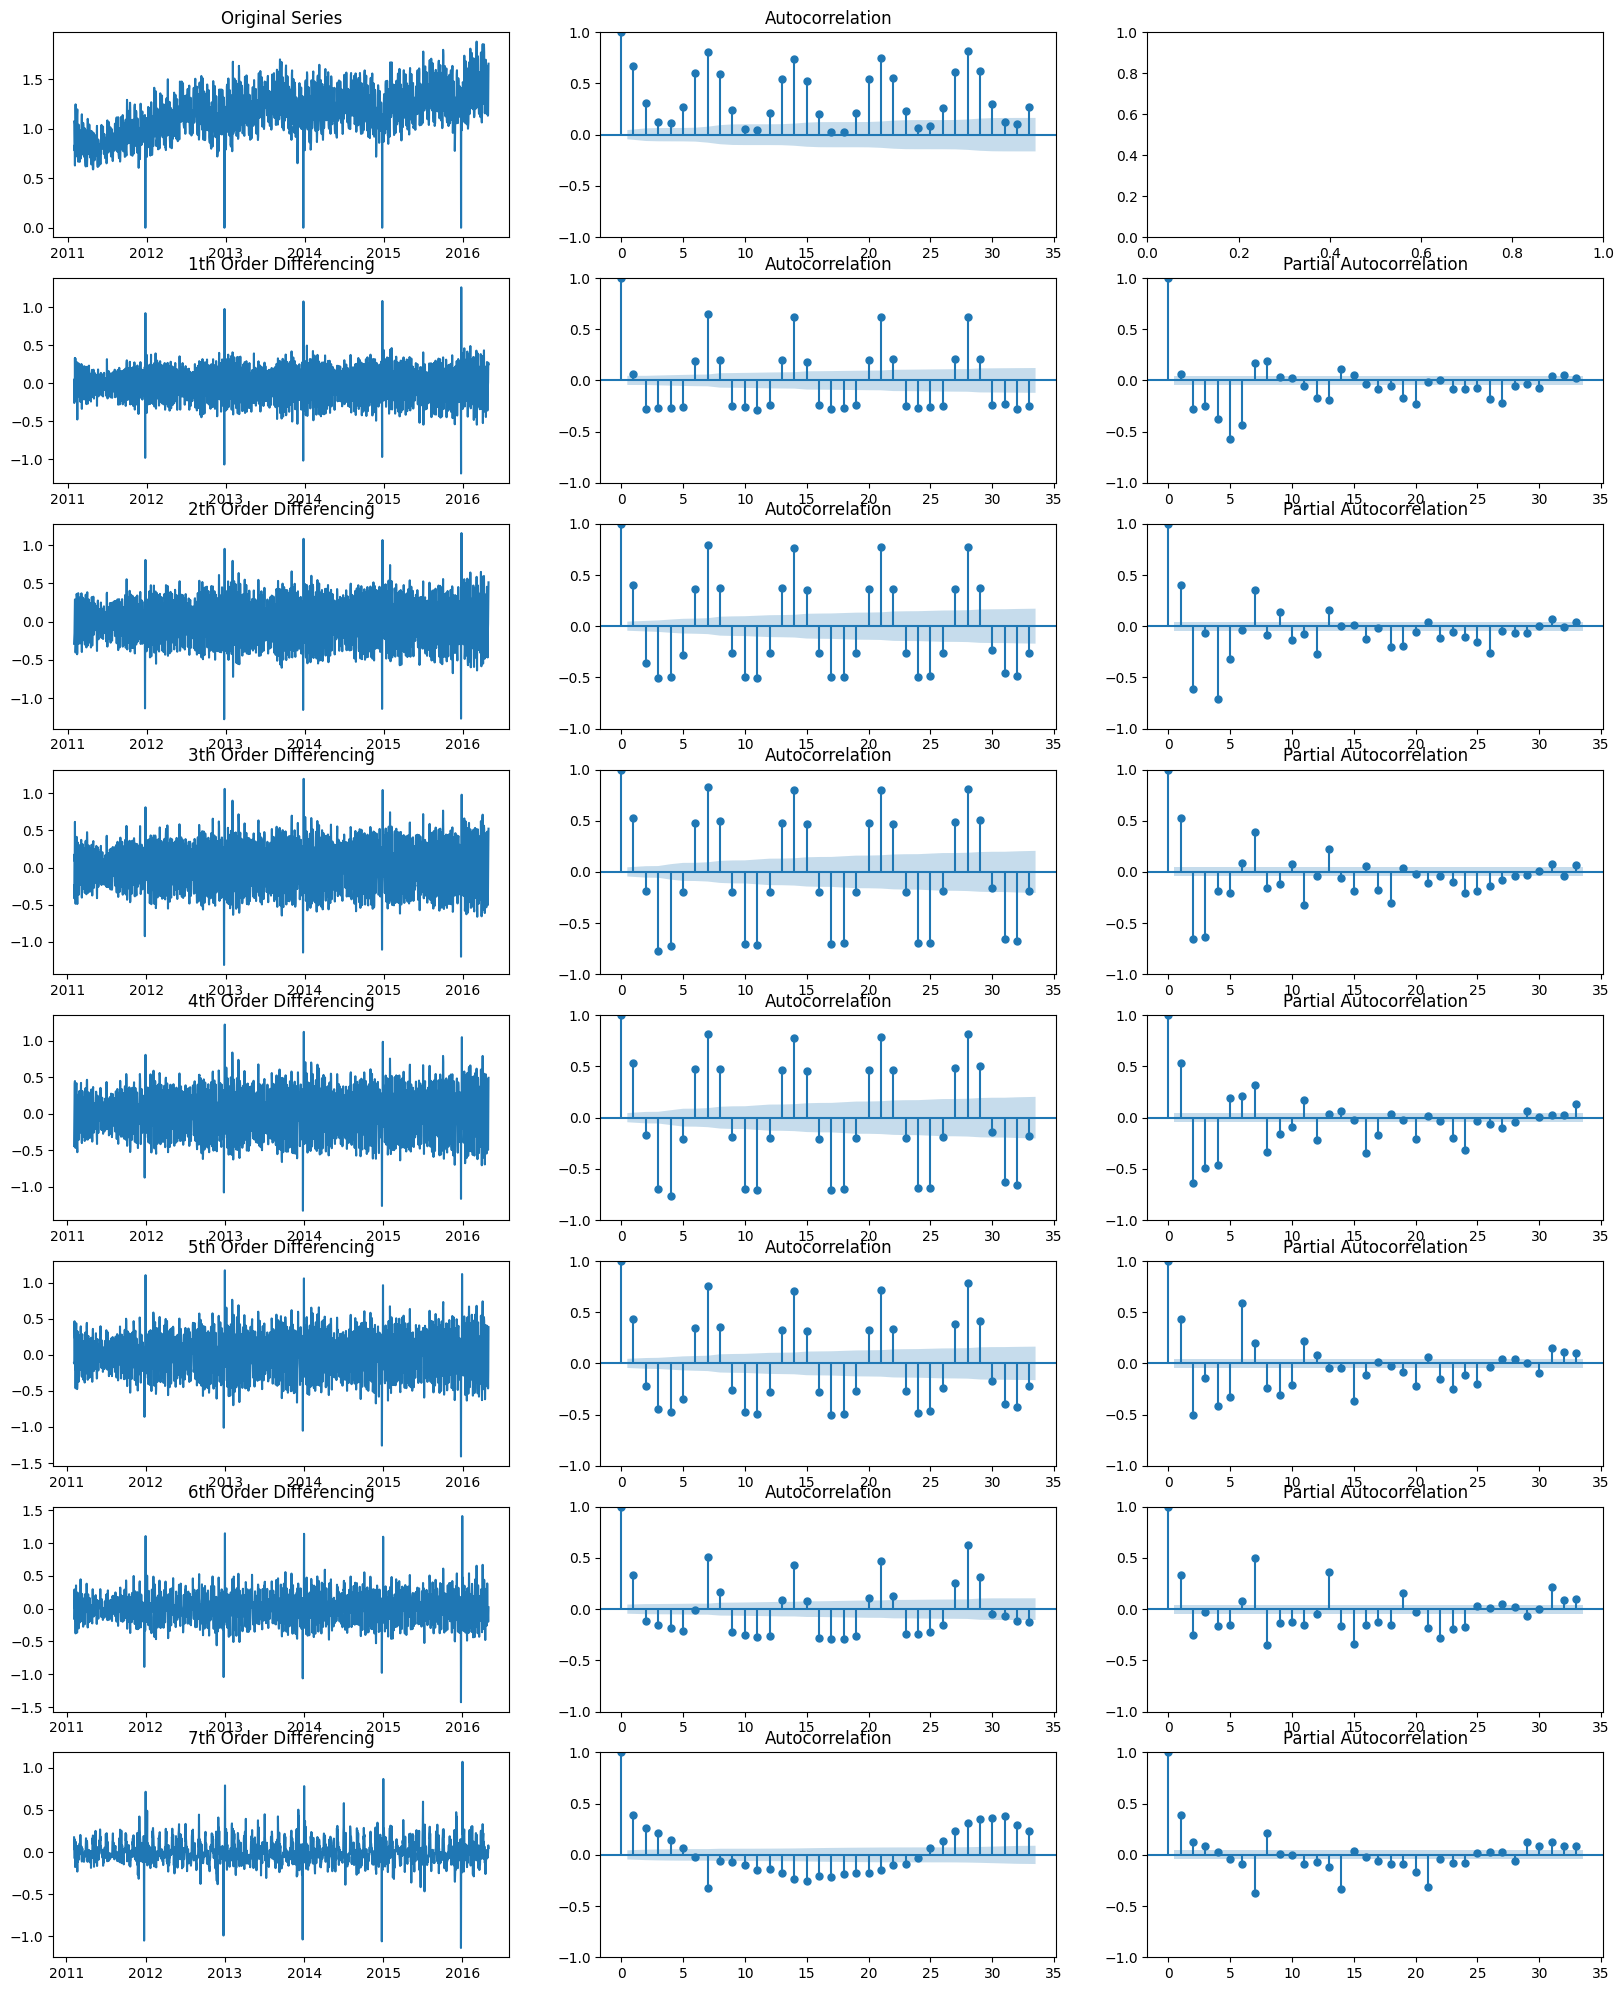

In [7]:
plot_differencing(df_items_temp["avg_items_sold"])

#### Test for stationarity after differencing by 7
Since the plots confirm seasonality at 7, we difference the data by 7 to try to remove the seasonality. We run the significance tests to see whether the data is stationary. As confirmed below, ADF test returns p < 0.05, meaning that we can reject H0 that the series is seasonal, and prefer H1 that series is stationary.

KPSS test the p > 0.1, meaning that we cannot reject H0 that the series is stationary. So both tests show that the time series is stationary.

In [8]:
adf_test(df_items_temp["avg_items_sold"].diff(periods = 7).dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -20.958364
p-value                           0.000000
#Lags Used                       23.000000
Number of Observations Used    1888.000000
Critical Value (1%)              -3.433818
Critical Value (5%)              -2.863072
Critical Value (10%)             -2.567586
dtype: float64


In [9]:
kpss_test(df_items_temp["avg_items_sold"].diff(periods = 7).dropna())

Results of KPSS Test:
Test Statistic            0.008453
p-value                   0.100000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


### Testing ARIMA model on average items sold

First we tried fitting a SARIMA model on the mean items sold per day on the entire dataset (instead of per item per day to reduce computation) to capture some baseline performance

Looking at the SARIMA summary below, the only non statistically significant coefficient was MA1, but the rest of the coefficients are significant. Perhaps there could be some seasonal order of P, D, Q that we could consider trying different combinations of in future work. Other than this anomaly, it seems that the hypothesis of the parameters we inferred from the ACF and PACF plots are validated. Later on we tried using auto SARIMA to generate better parameters.

In [10]:
x = df_items_temp["avg_items_sold"]

model = ARIMA(x, order = (3, 1, 4), seasonal_order=(1,1,1,7))
fitted = model.fit()

print(fitted.summary())

c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                     SARIMAX Results                                     
Dep. Variable:                    avg_items_sold   No. Observations:                 1919
Model:             ARIMA(3, 1, 4)x(1, 1, [1], 7)   Log Likelihood                1605.472
Date:                           Sat, 29 Apr 2023   AIC                          -3190.943
Time:                                   14:34:49   BIC                          -3135.389
Sample:                               01-29-2011   HQIC                         -3170.498
                                    - 04-30-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6485      0.076     -8.584      0.000      -0.797      -0.500
ar.L2          0.2844      0.073      3.875

#### Residuals plot
Plot shows that the variance of the residuals seem quite constant, other than more granular seasonal spikes especially at the end of each year where the stores close.

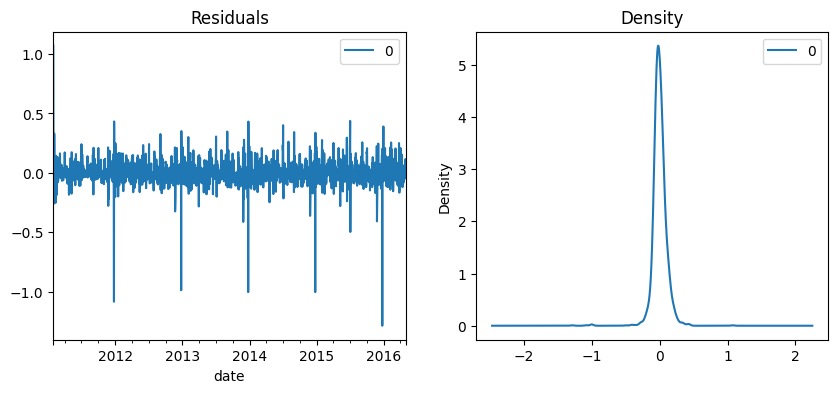

In [11]:
residuals = pd.DataFrame(fitted.resid)
fig, ax = plt.subplots(1,2, figsize = (10, 4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

### Actual values vs fitted predictions
Generally the model seems to follow the trend of the actual values, though the 95% CI is quite broad, which could mean that the model may not be as effective as visualised here.

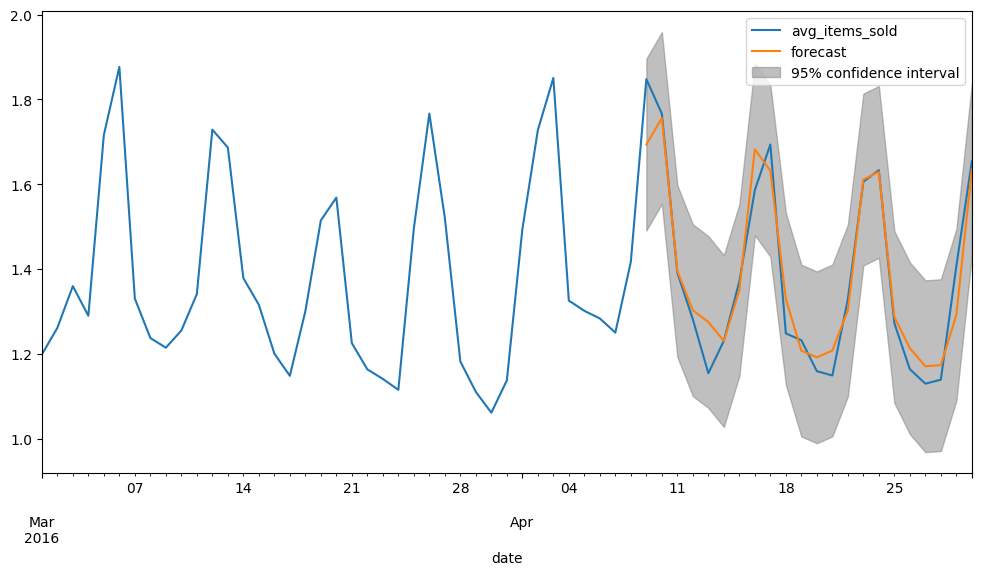

In [15]:
# Actual vs Fitted
fig, ax = plt.subplots(figsize = (12, 6))

# Compare predictions for the last 21 days of the training set
ax = df_items_temp["avg_items_sold"].loc["2016-03-01" : "2016-04-30"].plot(ax=ax)

# Predict until last day
plot_predict(fitted, "2016-04-09", "2016-04-30", ax = ax)
plt.show()

In [16]:
preds = fitted.get_prediction("2016-04-10", "2016-04-30")
rmse = np.sqrt(mean_squared_error(df_items_temp.loc["2016-04-10":"2016-04-30"]["avg_items_sold"], preds.predicted_mean))
print(rmse)

0.053642928899535806


### Forecasting with ARIMA for the last 21 days of the train dataset
Using 80% of the data to train, then testing on a forecast of the next 21 days after the 80% split. We test using a 21 days prediction because the required submission is 21 days, so this hopefully could give some benchmark performance.

In [17]:
# Set number of days to forecast into the future
n = 21

# Split into test and train, training up till the last n - 1th day and predict the last n days
x_train, x_test = x[0:len(x)-n], x[len(x) - n:]

# Build Model
model = ARIMA(x_train, order = (3, 1, 4), seasonal_order=(1,1,1,7))
fitted = model.fit()

# Forecast n days ahead
fc = fitted.forecast(n) 

# Make as pandas series
fc_series = pd.Series(fc, index=df_items_temp["avg_items_sold"][len(x) - n:].index)

print(fitted.summary())

c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                     SARIMAX Results                                     
Dep. Variable:                    avg_items_sold   No. Observations:                 1898
Model:             ARIMA(3, 1, 4)x(1, 1, [1], 7)   Log Likelihood                1585.211
Date:                           Sat, 29 Apr 2023   AIC                          -3150.422
Time:                                   14:38:22   BIC                          -3094.979
Sample:                               01-29-2011   HQIC                         -3130.006
                                    - 04-09-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7003      0.075     -9.329      0.000      -0.847      -0.553
ar.L2          0.1991      0.088      2.271

### Actual values (blue) vs fitted predictions (orange)
Similarly to the 80/20 split above, generally the model seems to follow the trend of the actual values for the next 21 days, though the forecasted values does not go as low as the actual values.

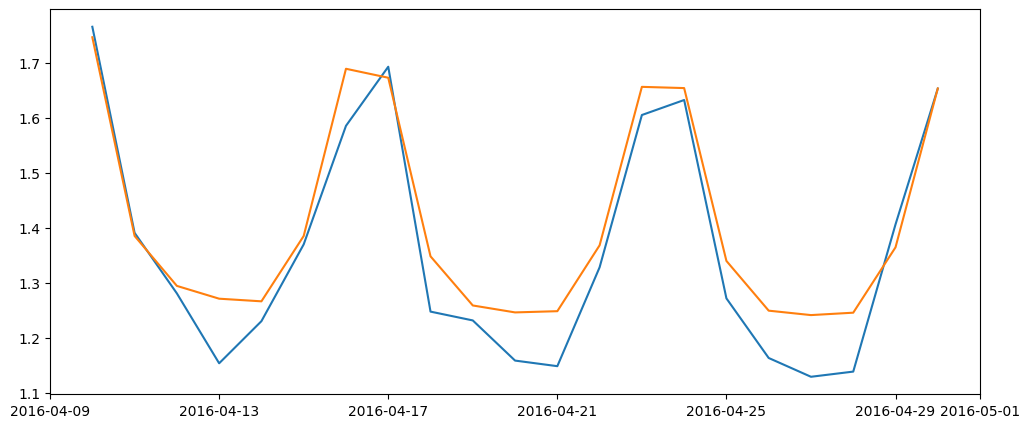

In [18]:
plt.figure(figsize=(12,5), dpi=100)
# plt.plot(x_train, label='training')
plt.plot(x_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.show()

Also comparing RMSE of when testing on the 21 days of forecast vs the 20% forecast above, the RMSE only had a difference of 0.01, which was quite insignificant. Perhaps we could infer that the model could capture both broader and narrower trends, because while the number of days of forecast varied greatly, RMSE was around the same value.

In [19]:
rmse = np.sqrt(mean_squared_error(x_test, fc_series))
print(rmse)

0.06837909782312342


### Simple ARIMA forecast, training data is taking the mean across all items of each day in the train dataset.

Forecast all 21 days at once and assign predictions to all the items for all days. This assumes that every item would sell the same number because the training data only contained 1 time series instead of one model per item.

Kaggle score: 3.82, which was the poorest score we got out of the other models we tried (ML, naive methods)

In [20]:
# Build Model -  just average items sold first
model = ARIMA(df_items_temp["avg_items_sold"], order = (3, 1, 4), seasonal_order=(1,1,1,7))
fitted = model.fit()

print(fitted.summary())

c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                     SARIMAX Results                                     
Dep. Variable:                    avg_items_sold   No. Observations:                 1919
Model:             ARIMA(3, 1, 4)x(1, 1, [1], 7)   Log Likelihood                1605.472
Date:                           Sat, 29 Apr 2023   AIC                          -3190.943
Time:                                   14:38:30   BIC                          -3135.389
Sample:                               01-29-2011   HQIC                         -3170.498
                                    - 04-30-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6485      0.076     -8.584      0.000      -0.797      -0.500
ar.L2          0.2844      0.073      3.875

In [21]:
# Forecast n days ahead
fc = fitted.forecast(21) 
pred_time_period = pd.date_range(start = "2016-05-01", periods = 21)

# Make as pandas series
fc_series = pd.Series(fc).round().astype(int)

# Assign to all items
df_sample_sub = pd.read_csv(SAMPLE_CSV_PATH)
df_sample_sub.iloc[:,1:] = fc_series.values

In [22]:
# Export
# df_sample_sub.to_csv(EXPORT_PATH+"/submission_1.csv", header=True, index=False)

### Using AUTOARIMA (on product category level)
Perhaps the performance above was due to poor parameter choices as we only inferred them from the ACF / PACF plots. Hence, to get a better indicator of the parameters to use for sarima, we first tried fitting autoarima on the averaged items sold, grouped by product category and producing forecasts on 20% of training set. Before doing this, we first aggregated data at product category level before forecasting.

In [23]:
# Group the data by store and item_id
df_category_grp = df_train.groupby(['category_id'], as_index=False).mean()

# Create datetime df matching to the day index
df_dates = pd.DataFrame(columns = ["d"], data = df_train.columns[6:])
df_dates = df_dates.merge(df_cal[["date", "d"]], on = "d", how = "left")

# Split into separate series, 1 for each category
s_beauty = pd.Series(list(df_category_grp.iloc[0,1:]), index = df_dates["date"])
s_food = pd.Series(list(df_category_grp.iloc[1,1:]), index = df_dates["date"])
s_cleaning = pd.Series(list(df_category_grp.iloc[2,1:]), index = df_dates["date"])

# Train test split
train, test = train_test_split(s_beauty, train_size=0.8)

# Save item indices for assigning predictions to the three product categories after forecasting
beauty_idx = df_train[df_train["category_id"] == "Beauty"].index
food_idx = df_train[df_train["category_id"] == "Food"].index
cleaning_idx = df_train[df_train["category_id"] == "Cleaning"].index

Here we fitted both ARIMA and SARIMA (seasonality = 7) to compare the performance. For both, we used a random grid search instead of the greedy stepwise algorithm for computational efficiency.

Looking at the summary, the AIC of SARIMA (-4117) was more negative than ARIMA (-3596), which gives us an indication that SARIMA is a btter model. Further, the coefficients have p values < 0.05, so they are significant and we can retain them.

Both models are also better than the original SARIMA that we just hypothesised from ACF / PACF plots. Hence, we could say that using auto arima produces better parameters than before.

In [24]:
# Fit a simple auto_arima model (not SARIMA)
modl = auto_arima(train, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=10, max_q=10, max_P=10, max_Q=10, 
                     seasonal=True, stepwise=False, random = True, n_jobs = -1, 
                     suppress_warnings=True, max_d=10, max_D=10,
                     trace = True, error_action='ignore')

print(modl.summary())


Best model:  ARIMA(2,1,3)(0,0,0)[1] intercept
Total fit time: 8.787 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1535
Model:               SARIMAX(2, 1, 3)   Log Likelihood                1805.156
Date:                Sat, 29 Apr 2023   AIC                          -3596.312
Time:                        14:38:41   BIC                          -3558.963
Sample:                    01-29-2011   HQIC                         -3582.414
                         - 04-12-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.838e-05   6.46e-05      1.059      0.290   -5.82e-05       0.000
ar.L1          1.1622      0.019     60.729      0.000

In [25]:
# Fit a seasonal auto_arima model (m = 7, weekly seasonality)
modl_seasonal = auto_arima(train, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=10, max_q=10, max_P=10, max_Q=10, max_d = 10, max_D=10, m = 7, 
                     seasonal=True, stepwise=False, random = True, n_jobs = -1, 
                     random_state = 0, suppress_warnings=True,
                     error_action='ignore', trace = True)

print(modl_seasonal.summary())


Best model:  ARIMA(0,1,3)(1,0,1)[7] intercept
Total fit time: 8.847 seconds
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1535
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 7)   Log Likelihood                2065.714
Date:                             Sat, 29 Apr 2023   AIC                          -4117.428
Time:                                     14:38:50   BIC                          -4080.079
Sample:                                 01-29-2011   HQIC                         -4103.530
                                      - 04-12-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.954e-06   5.34e

#### Predictions on 20% of data using AUTO ARIMA / SARIMA

We look at a few metrics: RMSE, the graphs including both the train, test and forecasted data, and another pair of graphs with just the test and forecasted data.

Though the SARIMA model seemed to perform very slightly worse than ARIMA using RMSE (0.109 vs 0.102), we see that the predictions produced by SARIMA probably captures more of the variance of the actual data points, vs ARIMA that produced a linear upwards trend. 

So we decided to continue using SARIMA with these parameters for the rest of the notebook.

In [26]:
# Create predictions for the future, evaluate on test
preds, conf_int = modl.predict(n_periods=test.shape[0], return_conf_int=True)

# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))

# Create predictions for the future, evaluate on test
preds_seasonal, conf_int_seasonal = modl_seasonal.predict(n_periods=test.shape[0], return_conf_int=True)

# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds_seasonal)))

Test RMSE: 0.102
Test RMSE: 0.109


Text(0.5, 1.0, 'Items sold for Beauty (ARIMA)')

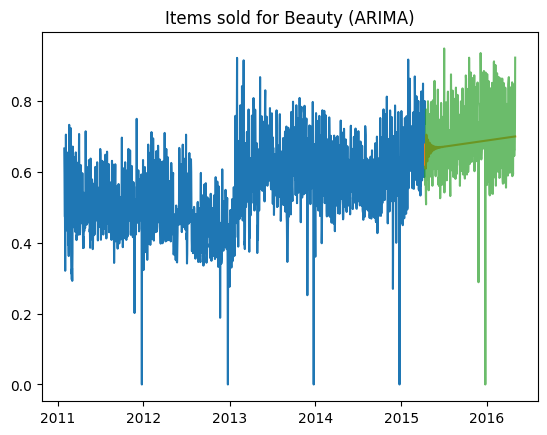

In [27]:
# Plot the points and the forecasts
plt.plot(train)
plt.plot(preds)
plt.plot(test, alpha = 0.7)
plt.title("Items sold for Beauty (ARIMA)")

Text(0.5, 1.0, 'Items sold for Beauty (SARIMA)')

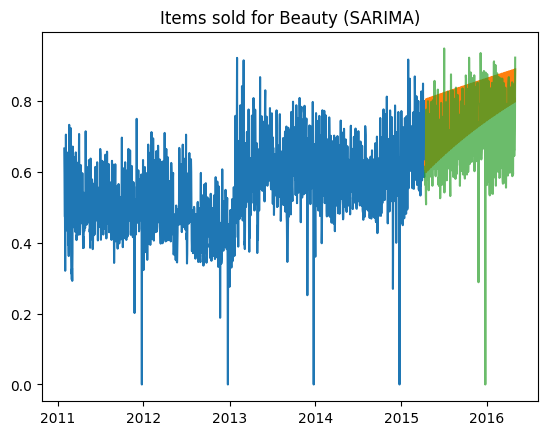

In [28]:
# Plot the points and the forecasts
plt.plot(train)
plt.plot(preds_seasonal)
plt.plot(test, alpha = 0.7)
plt.title("Items sold for Beauty (SARIMA)")

Text(0.5, 1.0, 'Forecasts (ARIMA) and preditions (testing on 20% of training data)')

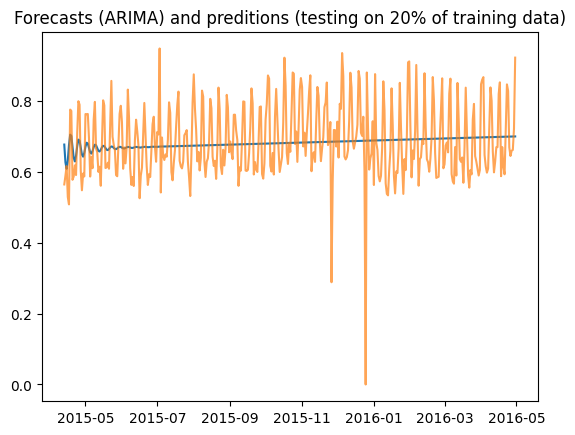

In [29]:
plt.plot(preds)
plt.plot(test, alpha = 0.7)
plt.title("Forecasts (ARIMA) and preditions (testing on 20% of training data)")

Text(0.5, 1.0, 'Forecasts (SARIMA) and preditions (testing on 20% of training data)')

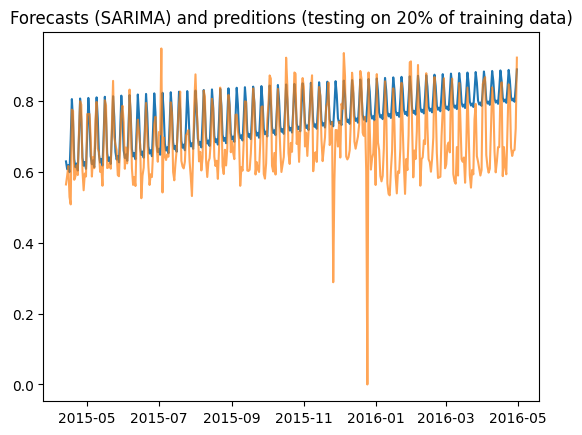

In [30]:
plt.plot(preds_seasonal)
plt.plot(test, alpha = 0.7)
plt.title("Forecasts (SARIMA) and preditions (testing on 20% of training data)")

### Fitting Auto SARIMA models for each product category
We then generated predictions for each product category for the next 21 days according to the submission format. Since there were only three models for each category, to populate the submission csv, we assumed that all items in each category sold the same number.

Notably, fitting AUTO ARIMA on each product category yielded the same paramters for the model.

We got a Kaggle score of 3.89, which was quite bad in comparison to ML and naive models.

In [31]:
# Fit a seasonal auto_arima model (m = 7, weekly seasonality)
modl_seasonal_beauty = auto_arima(s_beauty, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=10, max_q=10, max_P=10, max_Q=10, max_d = 10, max_D=10, m = 7, 
                     seasonal=True, stepwise=False, random = True, n_jobs = -1, 
                     random_state = 0, suppress_warnings=True,
                     error_action='ignore', trace = True)

pred_beauty = modl_seasonal_beauty.predict(21).apply(np.ceil)


Best model:  ARIMA(0,1,3)(1,0,1)[7] intercept
Total fit time: 11.535 seconds


In [32]:
# Fit a seasonal auto_arima model (m = 7, weekly seasonality)
modl_seasonal_food = auto_arima(s_food, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=10, max_q=10, max_P=10, max_Q=10, max_d = 10, max_D=10, m = 7, 
                     seasonal=True, stepwise=False, random = True, n_jobs = -1, 
                     random_state = 0, suppress_warnings=True,
                     error_action='ignore', trace = True)

pred_food = modl_seasonal_food.predict(21).apply(np.ceil)


Best model:  ARIMA(0,1,3)(1,0,1)[7] intercept
Total fit time: 15.084 seconds


In [33]:
# Fit a seasonal auto_arima model (m = 7, weekly seasonality)
modl_seasonal_cleaning = auto_arima(s_cleaning, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=10, max_q=10, max_P=10, max_Q=10, max_d = 10, max_D=10, m = 7, 
                     seasonal=True, stepwise=False, random = True, n_jobs = -1, 
                     random_state = 0, suppress_warnings=True,
                     error_action='ignore', trace = True)

pred_cleaning = modl_seasonal_cleaning.predict(21).apply(np.ceil)


Best model:  ARIMA(0,1,3)(1,0,1)[7] intercept
Total fit time: 11.082 seconds


In [34]:
df_sample_sub = pd.read_csv(SAMPLE_CSV_PATH)

# Assign predictions to 
df_sample_sub.iloc[beauty_idx, 1:] = pred_beauty.values
df_sample_sub.iloc[cleaning_idx, 1:] = pred_cleaning.values
df_sample_sub.iloc[food_idx, 1:] = pred_food.values

# Export
# df_sample_sub.to_csv(EXPORT_PATH+"/submission_2.csv", header=True, index=False)

## Conclusion and future work

While the visualised forecasts seemed good, the Kaggle RMSE was quite poor with both ARIMA and SARIMA. Though SARIMA semmed to better capture the variance of the data, it still paled in comparison to naive methods and ML predictions. Most likely because we trained ARIMA and SARIMA on only the mean of items sold for each day, whereas the other 2 types of models were able to be trained on all the items of varying time periods. So while SARIMA seems to have good potential in capturing trends, it was limited by the training data.

Further, we suggest using AUTO SARIMA in future work as seen through the more negative AIC overall. While the ACF / PACF plots gives a good indication of seasonality, perhaps the p,d,q and P,D,Q parameters are hard to detect because there are underlying seasonalities beyond just the first 7 days.

Future work:
- According to the visualised forecasts on the test set and also the RMSE, it seems that just predicting on the average of items sold (and aggregated by product category) was quite successful. However, the Kaggle RMSE was quite poor. Perhaps the mean of the items sold of each day was a poor proxy of actual items sold. Hence, further work could be done to train models on smaller subsets of the data such as store (because there are 10 stores), or incorporating hierarchical forecasting to train models at different levels and then still be able to retain some of the information from these levels instead of losing all the details by taking the mean of all items to forecast.

- Keeping in mind that the visualised forecasts were predicting for 21 days and testing on the first 21 days of the next 20% of the train / test split. While the visualisations showed that the predictions closely followed the trend of the actual data, we are not sure whether the model actually captured more global trends. Hence, it could be worth considering other length of forecasts (such as > 21 days), to assess performance of the model.

- It is worth to try other combinations of AR and MA, including the seasonal order component, because the final models we used for submission on Kaggle were using a random grid search, so the globally optimal parameters might not be what was returned.